# 07. PyTorch Experiment Tracking

Machine learning is very experimental.

In order to figure out which experiments are worth pursuing, that's where **experiment tracking** comes in, it helps you to figure out what doesn't work so you can figure out what **does** work.

In this notebook, we're going to see an example of programmatically tracking experiments.

Resources:
* Book version of notebook: https://www.learnpytorch.io/07_pytorch_experiment_tracking/
* Ask a question: https://github.com/mrdbourke/pytorch-deep-learning/discussions
* Extra-curriculum: https://madewithml.com/courses/mlops/experiment-tracking/

In [1]:
import torch
import torchvision
from plotly.data import experiment
from sphinx.builders.gettext import timestamp
from torch import nn
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
from xlwings.utils import col_name

from going_modular import data_setup, engine
from going_modular.train import train_dataloader, test_dataloader, BATCH_SIZE

print(torch.__version__)
print(torchvision.__version__)

2.5.1
0.20.1


In [2]:
# Setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")
device

device(type='mps')

In [3]:
# Set seeds
def set_seeds(seed: int=42):
    """
    Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # the seed for general torch operations
    torch.manual_seed(seed)

    # Set the seed for CUDA+MPS torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)

In [4]:
set_seeds()

## 1. Get data

Want to get pizza, steak, sushi images.

So we can run experiments building FoodVision Mini and see which model performs best.

In [5]:
import os
import zipfile
from pathlib import Path
from typing import Optional

import requests
from tqdm.auto import tqdm


def download_data(
    source: str,
    destination: str,
    remove_source: bool = True,
    chunk_size: int = 1024
) -> Path:
    """Downloads a zipped dataset from source and unzips to destination."""

    data_path = Path("data")
    image_path = data_path / destination
    data_path.mkdir(parents=True, exist_ok=True)

    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
        return image_path

    print(f"[INFO] Creating directory {image_path}...")
    image_path.mkdir(parents=True, exist_ok=True)

    target_file = data_path / Path(source).name

    print(f"[INFO] Downloading {target_file.name}...")
    response = requests.get(source, stream=True)
    response.raise_for_status()

    total_size = int(response.headers.get("content-length", 0))

    with open(target_file, "wb") as f, tqdm(
        desc="Downloading",
        total=total_size,
        unit="B",
        unit_scale=True,
        unit_divisor=1024,
    ) as pbar:
        for chunk in response.iter_content(chunk_size=chunk_size):
            if chunk:
                f.write(chunk)
                pbar.update(len(chunk))


    print(f"[INFO] Unzipping {target_file.name}...")
    with zipfile.ZipFile(target_file, "r") as zip_ref:
        members = zip_ref.infolist()
        for member in tqdm(members, desc="Extracting", unit="file"):
            zip_ref.extract(member, image_path)

    if remove_source:
        target_file.unlink()

    print("[INFO] Download and extraction complete.")
    return image_path


image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders

### 2.1 Create DataLoaders with manual transforms
The goal with transforms is to ensure your custom data is formatted in a reproducible way as well as a way that will suit pretrained models.

In [6]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [7]:
# Setup ImageNet normalization levels
# See here: https://pytorch.org/vision/0.12/models.html
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.4061], std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms. Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])
print (f"Manually created transforms: {manual_transforms}")

# Create DataLoaders
from going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=manual_transforms,
                                                                               test_transform=manual_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.4061], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x305642b10>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

The same principle applies for automatically created transforms we want our custom data in the same format as the pretrained data the model trained on.

In [8]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights
import torchvision
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available

# Get the transforms from weights (these are the transforms used to train a particular or obtain a particular set of weights)
automatic_transforms = weights.transforms()
print (f"Automatically created transforms: {automatic_transforms}")
# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               train_transform=automatic_transforms,
                                                                               test_transform=automatic_transforms,
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x305f5e300>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freeze the base layers and change the classifier head

In [9]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = best available
model = torchvision.models.efficientnet_b0(weights= weights).to(device)

In [10]:
# Freeze all base layers by setting their requires_grad attribute to False
for param in model.features.parameters():
    # print(param)
    param.requires_grad = False

In [11]:
# Adjust the classifier head
set_seeds()
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

In [12]:
from torchinfo import summary

summary(model,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. train a single model and track results

In [13]:
# Define loss function optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

To track experiments, we're going to use TensorBoard: https://www.tensorflow.org/tensorboard

And to interact with IensorBoard, we can use PyTorch's Summarywriter - https:// pytorch.org/docs/stable/tensorboard.html
* Also see here: https://pytorch.org/docs/stable/tensorboard.html#torch.utils.tensorboard.writer.Summarywriter

In [14]:
# Setup a SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [15]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: SummaryWriter = writer) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics. Each metric has a value in a list for
        each epoch.
        In the form: {train_loss: [...],
        train_acc: [...],
        test_loss: [...],
        test_acc: [...]}

    For example if training for epochs=2:
        {train_loss: [2.0616, 1.0537],
        train_acc: [0.3945, 0.3945],
        test_loss: [1.2641, 1.5706],
        test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    model.to(device)
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
              )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Experiment tracking
        writer.add_scalars(main_tag="Loss",
                          tag_scalar_dict={"train_loss":train_loss,
                                           "test_loss": test_loss},
                          global_step=epoch)
        writer.add_scalars(main_tag="Accuracy",
                          tag_scalar_dict={"train_acc":train_acc,
                                           "test_acc": test_acc},
                          global_step=epoch)
    writer.add_graph(model=model,
                     input_to_model=torch.randn(32, 3, 224, 224).to(device))

    # Close the writer
    writer.close()
    ## End new ##

    # Return the filled results at the end of the epochs
    return results

In [17]:
# Train model
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results

## 5. View our models results with TensorBoard

There are a few ways to view TensorBoard results:
https://www.tensorflow.org/tensorboard/get_started

In [19]:
import shutil
import sys
import os

print("Python:", sys.executable)
print("TensorBoard:", shutil.which("tensorboard"))


Python: /opt/anaconda3/bin/python
TensorBoard: /opt/anaconda3/bin/tensorboard


In [20]:
import os
import sys

tb_path = os.path.join(os.path.dirname(sys.executable), "tensorboard")
os.environ["TENSORBOARD_BINARY"] = tb_path

print("Using TensorBoard at:", tb_path)


Using TensorBoard at: /opt/anaconda3/bin/tensorboard


In [21]:
%reload_ext tensorboard

In [22]:
%tensorboard --logdir runs

## 6. Create a function to prepare `SummaryWriter()` instance

By default, our `SummaryWriter()` class saves to `runs`.

How about if we wanted to save different examples to different folders?

In essence, one experiment = one folder.

For example, we'd like to track:
* Experiment date/timestamp
* Experiment name
* Model name
* Extra - is there anything else that should be tracked?

Let's create a function to create a `SummaryWriter()` instance to take all of these things into account.

So ideally we end up tracking experiments to a directory:

`runs/YYYY-MM-DD/experiment_name/model_name/extra`

In [23]:
from torch.utils.tensorboard import SummaryWriter
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None) -> SummaryWriter:
    """
    Creates a torch.utils.tensorboard.SummaryWriter instance tracking to a specific directory.

    Args:
        experiment_name: The name of the experiment.
        model_name: The name of the model.
        extra: An optional string to append to the experiment name.

    Returns:
        A SummaryWriter instance.
    """
    from datetime import datetime
    import os

    # Get timestamp of current date in reverse order
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir=log_dir)

In [24]:
from datetime import datetime
timestamp = datetime.now().strftime("%Y-%m-%d")
timestamp

'2025-12-15'

In [25]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")
example_writer

[INFO] Created SummaryWriter saving to runs/2025-12-15/data_10_percent/effnetb0/5_epochs


### 6.1 Update the `train()` function to include a writer parameter

In [26]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          writer: SummaryWriter = None) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be trained and tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        loss_fn: A PyTorch loss function to calculate loss on both datasets.
        epochs: An integer indicating how many epochs to train for.
        device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics. Each metric has a value in a list for
        each epoch.
        In the form: {train_loss: [...],
        train_acc: [...],
        test_loss: [...],
        test_acc: [...]}

    For example if training for epochs=2:
        {train_loss: [2.0616, 1.0537],
        train_acc: [0.3945, 0.3945],
        test_loss: [1.2641, 1.5706],
        test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
               }

    model.to(device)
    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
              )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Experiment tracking
        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss":train_loss,
                                               "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc":train_acc,
                                               "test_acc": test_acc},
                               global_step=epoch)
            writer.add_graph(model=model,
                             input_to_model=torch.randn(32, 3, 224, 224).to(device))

            # Close the writer
            writer.close()
    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments
* Challenge: Setup 2x modeling experiments with efnetto, pizza, steak sushi data and train one model for 5 epochs and another model for 10 epochs

### 7.1 What kind of experiments should you run?

The number of machine learning experiments you can run, is like the number of different models you can build... almost limitless.

However, you can't test everything...

So what should you test?
* Change the number of epochs
* Change the number of hidden layers/units
* Change the amount of data (right now we're using 10% of the Food101 dataset for pizza, steak, sushi)
* Change the learning rate
* Try different kinds of data augmentation
* Choose a different model architecture

This is why transfer learning is powerful, because it's a working model that you can apply to your own problem

### 7.2 What experiments are we going to run?

We're going to turn 3 dials:
1. Model size - EffnetB0 vs EffnetB2 (in terms of number of params)
2. Dataset size - 10% of pizza, steak, sushi images vs 20% (generally more data = better results)
3. Training time - 5 epochs vs 10 epochs (generally longer training time = better
results... before the model starts to overfit)

To begin, we're still keeping things relatively small so that our experiments run quickly.

**Our goal:** a model that is well performing but still small enough to run on a mobile device or web browser, so FoodVision Mini can come to life.

If you had infinite compute + time, you should basically always choose the biggest model and biggest dataset you can.
http://www.incompleteideas.net/Incldeas/BitterLesson.html

### 7.3 Download different dataset

We want two datasets:

1. Pizza, steak, sushi 10% - https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
2. Pizza, steak, sushi 20% - https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip

They were created with: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb

In [27]:
# Download 10% and 20% datasets
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


### 7.4 Transform Datasets and Create DataLoaders

We'll need to transform our data in a few ways:
1. Resize the images to (224, 224)
2. Make sure image tensor values are between [0, 1]
3. Normalize the images so they have the same data distribution as ImageNet

In [28]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup the test directory
test_dir = data_10_percent_path / "test"

train_dir_10_percent, train_dir_20_percent, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [29]:
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" = best available

# Get the transforms from weights (these are the transforms used to train a particular or obtain a particular set of weights)
simple_transform = weights.transforms()
simple_transform

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [30]:
BATCH_SIZE = 32

# Create 10% training and test Dataloaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
                                                                               test_dir=test_dir,
                                                                               train_transform=simple_transform,
                                                                               test_transform=simple_transform,
                                                                               batch_size=BATCH_SIZE)
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                               test_dir=test_dir,
                                                                               train_transform=simple_transform,
                                                                               test_transform=simple_transform,
                                                                               batch_size=BATCH_SIZE)

print(f"Number of batches: {len(train_dataloader_10_percent)=}")
print(f"Number of batches: {len(train_dataloader_20_percent)=}")
print(f"Number of batches: {len(test_dataloader)=}")
print(f"Class names: {class_names}")

Number of batches: len(train_dataloader_10_percent)=8
Number of batches: len(train_dataloader_20_percent)=15
Number of batches: len(test_dataloader)=3
Class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models
We want two functions:
1. Creates a `torchvision.models efficientnet_b0()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB0).
2. Creates a `torchvision.models.efficientnet_b2()` feature extractor with a frozen backbone/base layers and a custom classifier head (EffNetB2).

In [31]:
import torchvision

# Create an EffNetB2
effnetB2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT  # "DEFAULT" = best available
effnetB2 = torchvision.models.efficientnet_b2(weights=effnetB2_weights).to(device)

effnetB2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [32]:
summary(effnetB2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [33]:
import torchvision
from torch import nn

OUT_FEATURES = len(class_names)

# Create an EffNetB0
def create_effnetB0(device=device):
    # Get the weights and setup a model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # "DEFAULT" = best available
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze all base model layers
    for param in model.features.parameters():
        param.requires_grad = False
      # Change the classifier head

    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
    ).to(device)

    # Give the model a name
    model.name = "effnetB0"
    print(f"[INFO] Created new model: {model.name}")
    return model

# Create an EffNetB2
def create_effnetB2(device=device):
    # Get the weights and setup a model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT  # "DEFAULT" = best available
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # Freeze all base model layers
    for param in model.features.parameters():
        param.requires_grad = False
      # Change the classifier head

    set_seeds()
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
    ).to(device)

    # Give the model a name
    model.name = "effnetB2"
    print(f"[INFO] Created new model: {model.name}")
    return model

In [34]:
effnetB2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [35]:
created_model_test_effnetB0 = create_effnetB0()
created_model_test_effnetB2 = create_effnetB2()

[INFO] Created new model: effnetB0
[INFO] Created new model: effnetB2


In [36]:
summary(created_model_test_effnetB0,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [37]:
summary(created_model_test_effnetB2,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

### 7.6 Create experiments and set up training code

In [38]:
# Create epoch list
num_epochs = [5, 10]

# Create models list ( need to create a new model for each experiment)
models = ["effnetB0", "effnetB2"]

# Create a DataLoaders dictionary
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

In [ ]:
%%time
from going_modular.utils import save_model

# Set seeds
set_seeds()

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through the epochs
    for epochs in num_epochs:
        # Loop through each model name and create a new model instance
        for model_name in models:
            if experiment_number in range(6):
                experiment_number+=1
                continue
            # Print out the info
            print(f"[INFO] Experiment {experiment_number} | Number of Epochs {epochs} | Model: {model_name} | DataLoader: {dataloader_name}")

            if model_name == "effnetB0":
                model = create_effnetB0(device=device)
            else:
                model = create_effnetB2(device=device)

            # Create a new loss and optimizer
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())

            # Train target model with target dataloader and track experiments
            writer = create_writer(
                experiment_name= dataloader_name,
                model_name=model_name,
                extra=f"{epochs}_epochs",
            )

            train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, writer)

            # Save the model to file so we can import it late if needed
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            del model
            print("-"*50 + "\n")
            experiment_number += 1

[INFO] Experiment 0 | Number of Epochs 5 | Model: effnetB0 | DataLoader: data_10_percent
[INFO] Created new model: effnetB0
[INFO] Created SummaryWriter saving to runs/2025-12-15/data_10_percent/effnetB0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0427 | train_acc: 0.5000 | test_loss: 0.9384 | test_acc: 0.4886
Epoch: 2 | train_loss: 0.9193 | train_acc: 0.5664 | test_loss: 0.8126 | test_acc: 0.7017
Epoch: 3 | train_loss: 0.7880 | train_acc: 0.7344 | test_loss: 0.6786 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.7088 | train_acc: 0.7578 | test_loss: 0.5752 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.5777 | train_acc: 0.8984 | test_loss: 0.5424 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetB0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment 1 | Number of Epochs 5 | Model: effnetB2 | DataLoader: data_10_percent
[INFO] Created new model: effnetB2
[INFO] Created SummaryWriter saving to runs/2025-12-15/data_10_percent/effnetB2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0778 | train_acc: 0.3828 | test_loss: 0.9241 | test_acc: 0.7027
Epoch: 2 | train_loss: 0.8731 | train_acc: 0.6523 | test_loss: 0.8491 | test_acc: 0.7746
Epoch: 3 | train_loss: 0.8241 | train_acc: 0.6836 | test_loss: 0.7525 | test_acc: 0.7955
Epoch: 4 | train_loss: 0.6975 | train_acc: 0.8633 | test_loss: 0.6319 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.7063 | train_acc: 0.7461 | test_loss: 0.5752 | test_acc: 0.8968
[INFO] Saving model to: models/07_effnetB2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment 2 | Number of Epochs 10 | Model: effnetB0 | DataLoader: data_10_percent
[INFO] Created new model: effnetB0
[INFO] Created SummaryWriter saving to runs/2025-12-15/data_10_percent/effnetB0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0427 | train_acc: 0.5000 | test_loss: 0.9384 | test_acc: 0.4886
Epoch: 2 | train_loss: 0.9193 | train_acc: 0.5664 | test_loss: 0.8126 | test_acc: 0.7017
Epoch: 3 | train_loss: 0.7880 | train_acc: 0.7344 | test_loss: 0.6786 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.7088 | train_acc: 0.7578 | test_loss: 0.5752 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.5777 | train_acc: 0.8984 | test_loss: 0.5424 | test_acc: 0.9280
Epoch: 6 | train_loss: 0.5564 | train_acc: 0.8711 | test_loss: 0.5753 | test_acc: 0.8665
Epoch: 7 | train_loss: 0.6094 | train_acc: 0.7383 | test_loss: 0.5773 | test_acc: 0.8153
Epoch: 8 | train_loss: 0.4828 | train_acc: 0.9219 | test_loss: 0.4920 | test_acc: 0.9271
Epoch: 9 | train_loss: 0.4853 | train_acc: 0.9531 | test_loss: 0.4581 | test_acc: 0.9271
Epoch: 10 | train_loss: 0.5806 | train_acc: 0.7852 | test_loss: 0.4222 | test_acc: 0.9271
[INFO] Saving model to: models/07_effnetB0_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0778 | train_acc: 0.3828 | test_loss: 0.9241 | test_acc: 0.7027
Epoch: 2 | train_loss: 0.8731 | train_acc: 0.6523 | test_loss: 0.8491 | test_acc: 0.7746
Epoch: 3 | train_loss: 0.8241 | train_acc: 0.6836 | test_loss: 0.7525 | test_acc: 0.7955
Epoch: 4 | train_loss: 0.6975 | train_acc: 0.8633 | test_loss: 0.6319 | test_acc: 0.8968
Epoch: 5 | train_loss: 0.7063 | train_acc: 0.7461 | test_loss: 0.5752 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5833 | train_acc: 0.9180 | test_loss: 0.5921 | test_acc: 0.8873
Epoch: 7 | train_loss: 0.5872 | train_acc: 0.8086 | test_loss: 0.5439 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.5197 | train_acc: 0.8281 | test_loss: 0.5317 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.4757 | train_acc: 0.9062 | test_loss: 0.4805 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.5111 | train_acc: 0.8320 | test_loss: 0.4900 | test_acc: 0.8977
[INFO] Saving model to: models/07_effnetB2_data_10_percent_10_epochs.pth
------------------------------------

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9425 | train_acc: 0.5896 | test_loss: 0.6304 | test_acc: 0.9167
Epoch: 2 | train_loss: 0.6905 | train_acc: 0.8021 | test_loss: 0.5376 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5547 | train_acc: 0.8396 | test_loss: 0.4534 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4524 | train_acc: 0.8979 | test_loss: 0.3699 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.4354 | train_acc: 0.8979 | test_loss: 0.3449 | test_acc: 0.9489
[INFO] Saving model to: models/07_effnetB0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment 5 | Number of Epochs 5 | Model: effnetB2 | DataLoader: data_20_percent
[INFO] Created new model: effnetB2
[INFO] Created SummaryWriter saving to runs/2025-12-15/data_20_percent/effnetB2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9705 | train_acc: 0.5958 | test_loss: 0.7325 | test_acc: 0.8968
Epoch: 2 | train_loss: 0.6960 | train_acc: 0.8083 | test_loss: 0.6149 | test_acc: 0.8873
Epoch: 3 | train_loss: 0.5320 | train_acc: 0.8896 | test_loss: 0.4976 | test_acc: 0.8977
Epoch: 4 | train_loss: 0.4987 | train_acc: 0.8667 | test_loss: 0.4719 | test_acc: 0.9081
Epoch: 5 | train_loss: 0.4588 | train_acc: 0.8292 | test_loss: 0.3887 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetB2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment 6 | Number of Epochs 10 | Model: effnetB0 | DataLoader: data_20_percent
[INFO] Created new model: effnetB0
[INFO] Created SummaryWriter saving to runs/2025-12-15/data_20_percent/effnetB0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9425 | train_acc: 0.5896 | test_loss: 0.6304 | test_acc: 0.9167
Epoch: 2 | train_loss: 0.6905 | train_acc: 0.8021 | test_loss: 0.5376 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5547 | train_acc: 0.8396 | test_loss: 0.4534 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4524 | train_acc: 0.8979 | test_loss: 0.3699 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.4354 | train_acc: 0.8979 | test_loss: 0.3449 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3987 | train_acc: 0.9000 | test_loss: 0.3116 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.3499 | train_acc: 0.9104 | test_loss: 0.2795 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3392 | train_acc: 0.8917 | test_loss: 0.2911 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3411 | train_acc: 0.9000 | test_loss: 0.2938 | test_acc: 0.9280


In [40]:
%%time
from going_modular.utils import save_model

# Set seeds
set_seeds()

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through the epochs
    for epochs in num_epochs:
        # Loop through each model name and create a new model instance
        for model_name in models:
            if experiment_number in range(6):
                experiment_number+=1
            else:
                # Print out the info
                print(f"[INFO] Experiment {experiment_number} | Number of Epochs {epochs} | Model: {model_name} | DataLoader: {dataloader_name}")

                if model_name == "effnetB0":
                    model = create_effnetB0(device=device)
                else:
                    model = create_effnetB2(device=device)

                # Create a new loss and optimizer
                loss_fn = nn.CrossEntropyLoss()
                optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())

                # Train target model with target dataloader and track experiments
                writer = create_writer(
                    experiment_name= dataloader_name,
                    model_name=model_name,
                    extra=f"{epochs}_epochs",
                )

                train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs, device, writer)

                # Save the model to file so we can import it late if needed
                save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs_.pth"
                save_model(model=model,
                           target_dir="models",
                           model_name=save_filepath)
                del model
                print("-"*50 + "\n")
                experiment_number += 1

[INFO] Experiment 6 | Number of Epochs 10 | Model: effnetB0 | DataLoader: data_20_percent
[INFO] Created new model: effnetB0
[INFO] Created SummaryWriter saving to runs/2025-12-15/data_20_percent/effnetB0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9425 | train_acc: 0.5896 | test_loss: 0.6304 | test_acc: 0.9167
Epoch: 2 | train_loss: 0.6905 | train_acc: 0.8021 | test_loss: 0.5376 | test_acc: 0.9176
Epoch: 3 | train_loss: 0.5547 | train_acc: 0.8396 | test_loss: 0.4534 | test_acc: 0.9176
Epoch: 4 | train_loss: 0.4524 | train_acc: 0.8979 | test_loss: 0.3699 | test_acc: 0.9688
Epoch: 5 | train_loss: 0.4354 | train_acc: 0.8979 | test_loss: 0.3449 | test_acc: 0.9489
Epoch: 6 | train_loss: 0.3987 | train_acc: 0.9000 | test_loss: 0.3116 | test_acc: 0.9176
Epoch: 7 | train_loss: 0.3499 | train_acc: 0.9104 | test_loss: 0.2795 | test_acc: 0.9280
Epoch: 8 | train_loss: 0.3392 | train_acc: 0.8917 | test_loss: 0.2911 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.3411 | train_acc: 0.9000 | test_loss: 0.2938 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.3709 | train_acc: 0.8896 | test_loss: 0.2386 | test_acc: 0.9384
[INFO] Saving model to: models/07_effnetB0_data_20_percent_10_epochs_.pth
-----------------------------------

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9705 | train_acc: 0.5958 | test_loss: 0.7325 | test_acc: 0.8968
Epoch: 2 | train_loss: 0.6960 | train_acc: 0.8083 | test_loss: 0.6149 | test_acc: 0.8873


python(8830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8835) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8836) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8837) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Epoch: 3 | train_loss: 0.5320 | train_acc: 0.8896 | test_loss: 0.4976 | test_acc: 0.8977


python(8909) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8910) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8911) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8912) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8914) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8915) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8916) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8967) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8968) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(8969) MallocStackLoggin

Epoch: 4 | train_loss: 0.4987 | train_acc: 0.8667 | test_loss: 0.4719 | test_acc: 0.9081


python(9057) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9058) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9059) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9060) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9061) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9062) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9064) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9150) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9151) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9152) MallocStackLoggin

Epoch: 5 | train_loss: 0.4588 | train_acc: 0.8292 | test_loss: 0.3887 | test_acc: 0.9280


python(9231) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9232) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9233) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9234) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9236) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9238) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9295) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9296) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9297) MallocStackLoggin

Epoch: 6 | train_loss: 0.3502 | train_acc: 0.9333 | test_loss: 0.4220 | test_acc: 0.9081


python(9340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9341) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9342) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9343) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9344) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9345) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9346) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9347) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9393) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9394) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9395) MallocStackLoggin

Epoch: 7 | train_loss: 0.3546 | train_acc: 0.9062 | test_loss: 0.3518 | test_acc: 0.8977


python(9431) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9434) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9435) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9436) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9437) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9438) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9478) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9479) MallocStackLoggin

Epoch: 8 | train_loss: 0.3104 | train_acc: 0.9354 | test_loss: 0.3570 | test_acc: 0.9081


python(9505) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9506) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9507) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9508) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9509) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9510) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9511) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9512) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9552) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9553) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9554) MallocStackLoggin

Epoch: 9 | train_loss: 0.3341 | train_acc: 0.9021 | test_loss: 0.3652 | test_acc: 0.9081


python(9592) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9593) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9595) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9596) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9597) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9598) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9599) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9630) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9631) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(9632) MallocStackLoggin

Epoch: 10 | train_loss: 0.3277 | train_acc: 0.8729 | test_loss: 0.3142 | test_acc: 0.9280
[INFO] Saving model to: models/07_effnetB2_data_20_percent_10_epochs_.pth
--------------------------------------------------

CPU times: user 1min 43s, sys: 3min 27s, total: 5min 10s
Wall time: 56min 53s


## 8. View experiments in TensorBoard

We've experimented...

Now let's visualize :D

In [41]:
# Let's view our experiments within TensorBoard from within the notebook
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


python(9692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


The best performing model was:
* Model: EffNetB2
* Dataset: Pizza, steak, sushi 20%
* Epochs: 10

And the overall trend of all the results was that more data, bigger model and longer training time generally led to better results.

In [42]:
# Upload the results to TensorBoard.dev (uncomment to try it out)
!tensorboard dev upload --logdir runs --name "07. PyTorch Experiment Tracking: FoodVision Mini model result" --description "Comparing results of different model size, training data amount and training time."

python(9707) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


TensorFlow installation not found - running with reduced feature set.
ERROR: The `tensorboard dev` command is no longer available.

TensorBoard.dev has been shut down. For further information,
see the FAQ at <https://tensorboard.dev/>.


You can view the experiments publicly at TensorBoard.dev: {TensorBoard.dev has been shut down}

# 9. Load in the best modal and create predictions with it
This is our best model filepath: `{THe file pth}`

In [44]:
# Setup best model file path
best_model_path = "models/07_effnetB0_data_20_percent_5_epochs.pth"

# Instantiate a new instance of EFFnetB0 (to load the saved state_dict())
best_model = create_effnetB0()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path, weights_only=False))

[INFO] Created new model: effnetB0


<All keys matched successfully>

Our goal: create a FoodVision Mini model that performs well enough and is able to run on a mobile device/web browser.

In [46]:
# Check the model file size
from pathlib import Path

# Get the model sioze in bytes then convert it to megabytes
effnetb0_model_size = Path(best_model_path).stat().st_size / (1_048_576)
print(f"EfficientNetB2 feature extractor model size: {effnetb0_model_size:.2f} MB")

EfficientNetB2 feature extractor model size: 15.59 MB


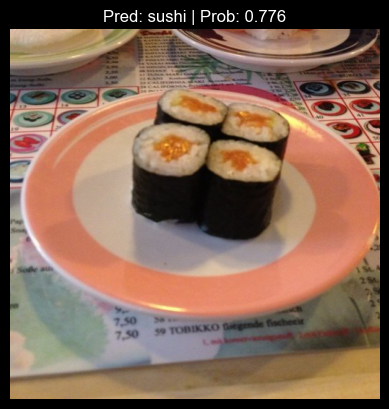

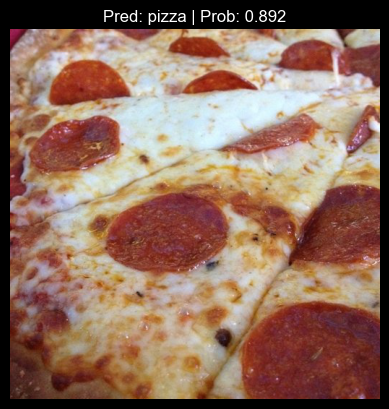

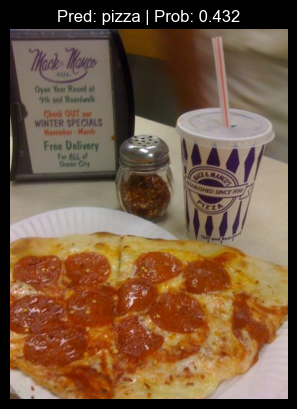

In [55]:
# Import function to make prediction on images and plot them
from going_modular.predictions import pred_and_plot_image

# Get a random list of 3 image path names from the test dataset
import random
num_images_to_plot = 3
test_image_paths_list = list(Path(data_20_percent_path/ "test").glob("*/*.jpg"))
test_image_paths_sample = random.sample(test_image_paths_list,
                                       k=num_images_to_plot)

for image_path in test_image_paths_sample:
    pred_and_plot_image(
        model=best_model,
        image_path=image_path,
        image_size=(224,224),
        class_names=class_names,
    )

## 9.1 Predict on a custom image

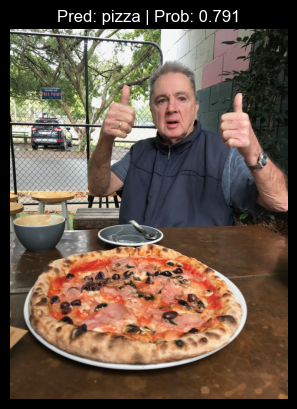

In [49]:
pred_and_plot_image(
    model=best_model,
    image_path=Path("data/04-pizza-dad.jpeg"),
    class_names=class_names,
)

# \# Progress updates

In [53]:
from Progress.course_progress_func import update_progress, progress_pie_chart, monthly_progress, progress_report_print
update_progress(video_index=221 , done=True)

Updated progress report. 
Video: 221. Main Takeaways, Exercises and Extra- Curriculum 
Duration: 4m 
Status: Done 
Date: 15 Dec 2025 02:53 PM 
Section progress: 
Section : 9.PyTorch Experiment Tracking
Status  : Done (22 videos | Total Duration: 3h 11m)
Progress: 100%|█████████████████████████████ 22/22


In [54]:
progress_report_print()

      ___         ___           ___           ___           ___           ___           ___           ___     
     /  /\       /  /\         /  /\         /  /\         /  /\         /  /\         /  /\         /  /\    
    /  /::\     /  /::\       /  /::\       /  /:/_       /  /::\       /  /:/_       /  /:/_       /  /:/_   
   /  /:/\:\   /  /:/\:\     /  /:/\:\     /  /:/ /\     /  /:/\:\     /  /:/ /\     /  /:/ /\     /  /:/ /\  
  /  /:/~/:/  /  /:/~/:/    /  /:/  \:\   /  /:/_/::\   /  /:/~/:/    /  /:/ /:/_   /  /:/ /::\   /  /:/ /::\ 
 /__/:/ /:/  /__/:/ /:/___ /__/:/ \__\:\ /__/:/__\/\:\ /__/:/ /:/___ /__/:/ /:/ /\ /__/:/ /:/\:\ /__/:/ /:/\:\
 \  \:\/:/   \  \:\/:::::/ \  \:\ /  /:/ \  \:\ /~~/:/ \  \:\/:::::/ \  \:\/:/ /:/ \  \:\/:/~/:/ \  \:\/:/~/:/
  \  \::/     \  \::/~~~~   \  \:\  /:/   \  \:\  /:/   \  \::/~~~~   \  \::/ /:/   \  \::/ /:/   \  \::/ /:/ 
   \  \:\      \  \:\        \  \:\/:/     \  \:\/:/     \  \:\        \  \:\/:/     \__\/ /:/     \__\/ /:/  
 